In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, f1_score

In [134]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test['Weather'] = np.zeros((len(test),))

train_end_idx = len(train)
test_end_idx = len(test)

dataset = pd.concat([train, test], sort = False)

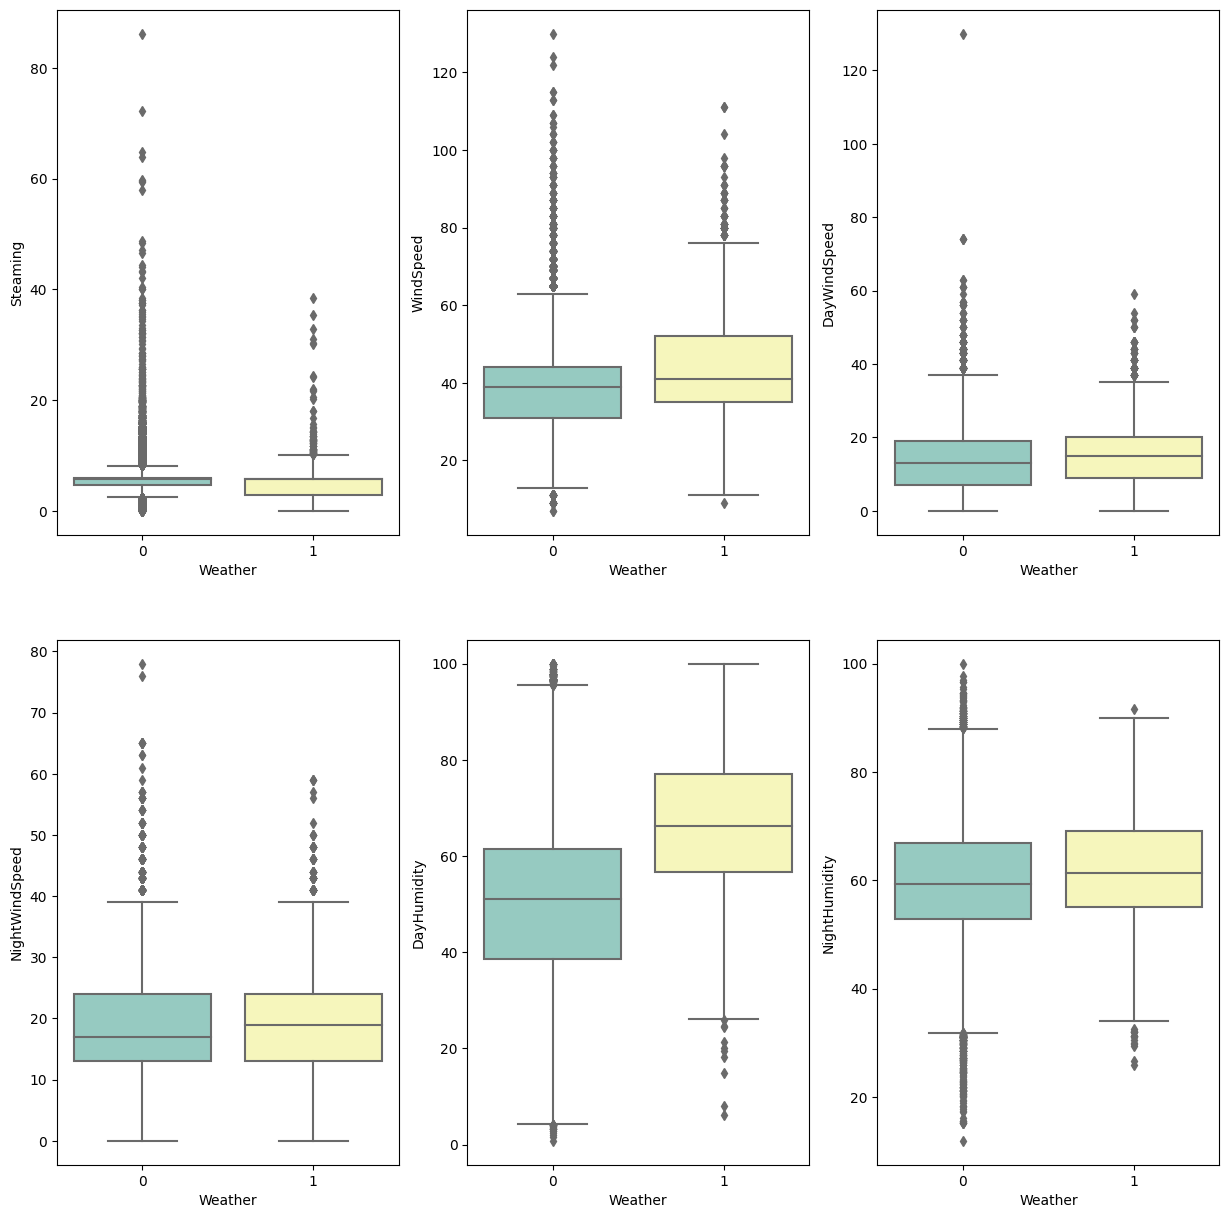

In [135]:
import seaborn as sns
figure, axes = plt.subplots(2, 3, figsize=(15, 15))

sns.boxplot(
    x = 'Weather', y = 'Steaming',
    data = train, ax = axes[0, 0], palette="Set3"
)

sns.boxplot(
    x = 'Weather', y = 'WindSpeed',
    data = train, ax = axes[0, 1], palette="Set3"
)

sns.boxplot(
    x = 'Weather', y = 'DayWindSpeed',
    data = train, ax = axes[0, 2], palette="Set3"
)

sns.boxplot(
    x = 'Weather', y = 'NightWindSpeed',
    data = train, ax = axes[1, 0], palette="Set3"
)

sns.boxplot(
    x = 'Weather', y = 'DayHumidity',
    data = train, ax = axes[1, 1], palette="Set3"
)

sns.boxplot(
    x = 'Weather', y = 'NightHumidity',
    data = train, ax = axes[1, 2], palette="Set3"
)

plt.show()

In [136]:
dataset.isnull().sum() / len(dataset)

Date              0.200814
Loc               0.201671
TempLow           0.198829
TempHigh          0.197514
Steaming          0.199729
Sun               0.200657
WindDir           0.248414
WindSpeed         0.197629
DayWindDir        0.255343
NightWindDir      0.220686
DayWindSpeed      0.200414
NightWindSpeed    0.198971
DayHumidity       0.200800
NightHumidity     0.200800
DayPressure       0.199486
NightPressure     0.201486
DayCloud          0.198714
NightCloud        0.199086
DayTemp           0.200429
NightTemp         0.199100
Weather           0.000000
RISK_MM           0.198157
dtype: float64

In [137]:
categorical = [col for col in dataset.columns if dataset[col].dtype == object]

In [138]:
categorical

['Date', 'Loc', 'WindDir', 'DayWindDir', 'NightWindDir']

In [139]:
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [140]:
dataset['Year'] = dataset['Date'].dt.year
dataset['Month'] = dataset['Date'].dt.month
dataset['Day'] = dataset['Date'].dt.day
pd.DataFrame(dataset.corr()).to_csv('correlation.csv')
dataset['Year'].fillna(dataset['Year'].median(), inplace = True)
dataset['Month'].fillna(dataset['Month'].median(), inplace = True)
dataset['Day'].fillna(dataset['Day'].median(), inplace = True)

dataset = dataset.drop(columns = 'Date')
#dataset = dataset.drop(columns = 'RISK_MM')

In [141]:
fill_list = ['Loc', 'WindDir', 'DayWindDir', 'NightWindDir']
fill_dict = {key : dataset[key].mode().values[0] for key in fill_list}
dataset.fillna(value = fill_dict, inplace = True)

In [142]:
for col in ['Loc', 'WindDir', 'DayWindDir', 'NightWindDir']:
    dataset = pd.concat([dataset, pd.get_dummies(dataset[col], prefix = col)], axis = 1)
    dataset = dataset.drop(columns = col)

In [143]:
from sklearn.impute import SimpleImputer

imr = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imr = imr.fit(dataset.values)
imputed_data = imr.transform(dataset.values)

df_impute = pd.DataFrame(imputed_data)
df_impute.columns = dataset.columns

dataset = df_impute

dataset.to_csv('aftertrain.csv')

In [144]:
from sklearn.model_selection import train_test_split

'''
X_train, X_eval, Y_train, Y_eval = train_test_split(
    dataset.drop(columns = ['Weather']).values[:train_end_idx, :],
    dataset['Weather'].values[:train_end_idx], test_size = 0.5)
'''

X_train = dataset.drop(columns = ['Weather']).values[:train_end_idx, :]
Y_train = dataset['Weather'].values[:train_end_idx]

X_test = dataset.drop(columns = ['Weather']).values[train_end_idx:, :]

In [145]:
#X_train, Y_train = RandomOverSampler().fit_resample(X_train, Y_train)
#X_train, Y_train = RandomUnderSampler().fit_resample(X_train, Y_train)
#X_train, Y_train = SMOTE().fit_resample(X_train, Y_train)
X_train, Y_train = SMOTEENN().fit_resample(X_train, Y_train)
#X_train, Y_train = SMOTETomek().fit_resample(X_train, Y_train)

In [146]:
#sc = StandardScaler()
#sc.fit(X_train)
#X_train_std = sc.transform(X_train)
#X_eval_std = sc.transform(X_eval)
#X_test = sc.transform(X_test)

In [147]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 200)
model.fit(X_train, Y_train)

y_pred_decision = model.predict(X_eval)
print('Accuracy: %f' % accuracy_score(Y_eval, y_pred_decision))
print('f1-score: %f' % f1_score(Y_eval, y_pred_decision))

ans_pred = model.predict(X_test)
df_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])
df_sap.to_csv('RandomForest.csv',  index_label = 'Id')


Accuracy: 0.914666
f1-score: 0.708964
